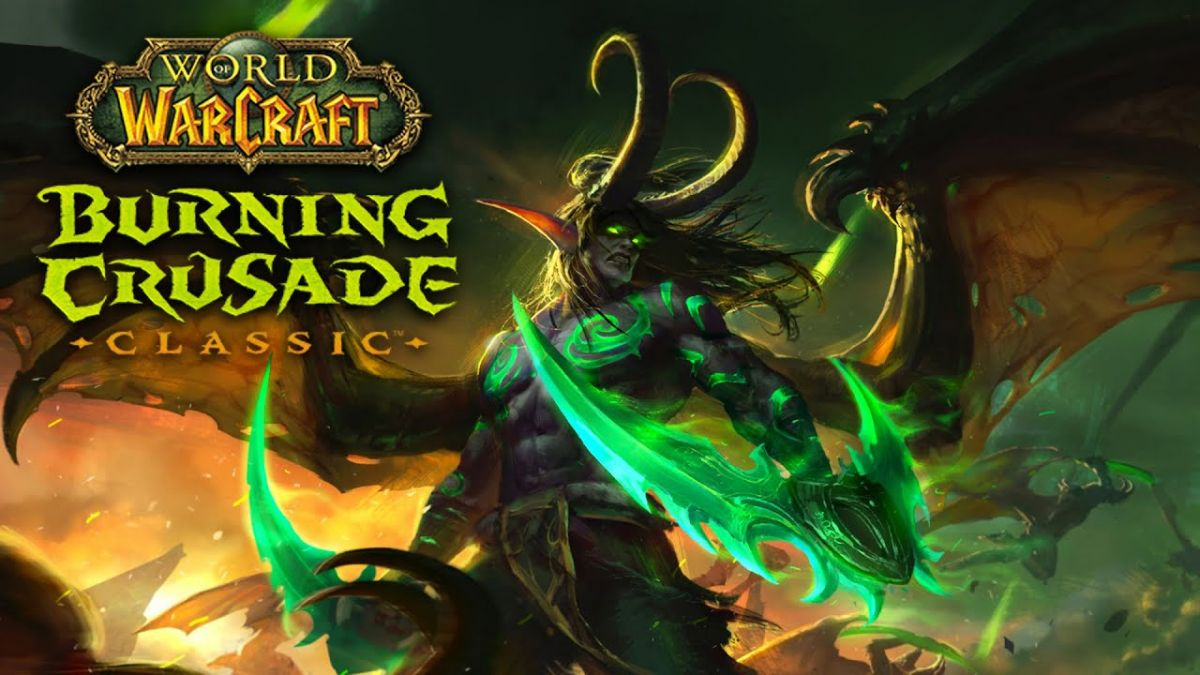

In [3]:
from IPython.display import Image
Image("wowtbc.jpg")

<center>
<span style="color:MediumSeaGreen;">
<span style="font-family:Brush Script MT;">
<font size="8"> World of Warcraft Combat Log Data Analysis
</font>
</span>
</span>
</center>

<span style="color:yellow;">
<span style="font-family:Comic Sans MS;">
<font size="4"> <b> This is an exploratory data analysis of combat data drawn from World of Warcrafts Combat Logs from various raid encounters in TBC Classic. We will sketch the main goals of this analysis.
    </b> <br> <br>
&#10004; Focus on Warrior Abilities <br>
&#10004; Extract & Plot the main statistical summary for each encounter per source per ability. <br>
&#10004; Extract & Plot the damage per second dealt & taken in a given encounter. <br>
&#10004; Extract & Plot the healing done in a given encounter. <br>
&#10004; Extract & Plot the cumulative damage per each ability in a given encounter. <br>
&#10004; Extract & Plot the source damage dealt cooldown timer and its percentange change across a given encounter. <br>
&#10004; Extract & Plot the damage distribution per spell (especially for the warrior class). <br>
&#10004; Explore the relationships between consumed rage & damage dealt as well as the distribution of rage consumption in various spells. <br>
&#10004; A tanking question: Estimate the crushing blow window of opportunity in a given fight when shield block is off. <br>
&#10004; Find the chained rotational sequences of spell usage by source. <br>
</font>
</span>
</span>

<div class="alert alert-block alert-warning">
<b>Warning! </b> Damage analysis does not include Pet damage or aura damage events (such as Thorns). Data are drawn only by source. This is not a bug and it will be implemented soon. </div>

In [381]:
import mysql.connector
import pandas as pd
import time
import os
import numpy as np
import matplotlib.patches as mpatches
import mplcyberpunk
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from functools import wraps
from mysqlconnection import SQL
import sys
plt.style.use('cyberpunk')
%matplotlib inline

In [382]:
def set_clock(func):
    """Decorator for performance benchmarking.
       It measures the execution time of a function in seconds rounded to two decimals."""
    
    @wraps(func)
    def wrapper(*args,**kwargs):
        tik = time.perf_counter()
        try:
            result = func(*args,**kwargs)
        except Exception as error:
            sys.stdout.write('Process could not complete due to the presence of the following error:\n')
            sys.stdout.write(error)
        finally:
            tak = time.perf_counter()
            sys.stdout.write("Process completed in {:1.2f} second(s).".format(tak-tik))
            return result
    return wrapper
    

<center>
<span style="color:MediumSeaGreen;">
<span style="font-family:Brush Script MT;">
<font size="8"> Part I: Exploratory Data Analysis
</font>
</span>
</span>
</center>

<center>
<span style="color:MediumSeaGreen;">
<span style="font-family:Brush Script MT;">
<font size="7"> Importing the Data
</font>
</span>
</span>
</center>

In [383]:
with SQL("wowlogsdb") as conn:
    df = pd.read_sql("SELECT * FROM damage",con=conn)
    df.drop(columns = ['rowid'],inplace=True)
df.head().style.background_gradient(subset = ['source_is_human',
                                              'dest_is_human',
                                              'mitigated_damage',
                                              'raw_damage',
                                              'blocked',
                                              'resisted',
                                              'absorbed'],cmap='summer')

,combat_time,log_event,encounter,spell_name,source,source_is_human,dest,dest_is_human,school,mitigated_damage,raw_damage,combat_event,blocked,resisted,absorbed
0,2021-12-12 02:52:31.528000,SWING_DAMAGE,Attumen the Huntsman,Auto Attack,Midnight,0,Lollitta,1,Physical,2020,5984,normal,344,0,0
1,2021-12-12 02:52:31.528000,SPELL_DAMAGE,Attumen the Huntsman,Devastate,Lollitta,1,Midnight,0,Physical,94,156,normal,0,0,0
2,2021-12-12 02:52:31.732000,SWING_DAMAGE,Attumen the Huntsman,Auto Attack,Lollitta,1,Midnight,0,Physical,188,304,normal,0,0,0
3,2021-12-12 02:52:33.037000,SPELL_DAMAGE,Attumen the Huntsman,Revenge,Lollitta,1,Midnight,0,Physical,268,434,normal,0,0,0
4,2021-12-12 02:52:33.329000,SWING_MISSED,Attumen the Huntsman,Auto Attack,Lollitta,1,Midnight,0,Physical,0,0,PARRY,0,0,0


In [384]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17321 entries, 0 to 17320
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   combat_time       17321 non-null  datetime64[ns]
 1   log_event         17321 non-null  object        
 2   encounter         17321 non-null  object        
 3   spell_name        17321 non-null  object        
 4   source            17321 non-null  object        
 5   source_is_human   17321 non-null  int64         
 6   dest              17321 non-null  object        
 7   dest_is_human     17321 non-null  int64         
 8   school            17321 non-null  object        
 9   mitigated_damage  17321 non-null  int64         
 10  raw_damage        17321 non-null  int64         
 11  combat_event      17321 non-null  object        
 12  blocked           17321 non-null  int64         
 13  resisted          17321 non-null  int64         
 14  absorbed          1732

<AxesSubplot:>

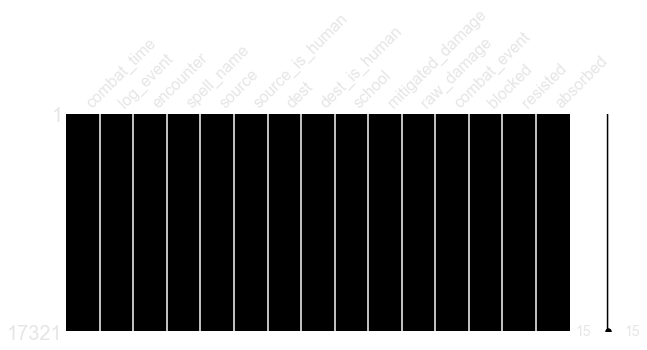

In [385]:
import missingno as mn
mn.matrix(df,color=(0,0,0),figsize=(10,4))

In [649]:
(df.describe(exclude=['object','datetime'])
   .style
   .format({col:'{:.2f}' for col in df.columns})
   .background_gradient(cmap='spring'))

,source_is_human,dest_is_human,mitigated_damage,raw_damage,blocked,resisted,absorbed,mitigated_norm
count,17321.00,17321.00,17321.00,17321.00,17321.00,17321.00,17321.00,17321.00
mean,0.68,0.13,653.06,730.04,6.03,20.53,0.96,-11986.21
std,0.47,0.33,943.67,1293.45,45.92,118.94,36.38,1.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-11986.90
25%,0.00,0.00,140.00,186.00,0.00,0.00,0.00,-11986.76
50%,1.00,0.00,288.00,313.00,0.00,0.00,0.00,-11986.60
75%,1.00,0.00,735.00,886.00,0.00,0.00,0.00,-11986.13
max,1.00,1.00,13514.00,24349.00,606.00,3470.00,2124.00,-11972.58


<center>
<span style="color:MediumSeaGreen;">
<span style="font-family:Brush Script MT;">
<font size="8"> Damage Per Encounter Per Source
</font>
</span>
</span>
</center>

In [387]:
@set_clock
def damage_per_source(df:pd.DataFrame,encounter_name:str) -> pd.DataFrame:
    df = df.loc[(df["encounter"] == encounter_name) & (df["source_is_human"] == 1)]
    grped = (df[["mitigated_damage","spell_name","source"]]
             .groupby(["source","spell_name"])
             .agg(["sum","min","max","mean","median"])
             #.groupby(level=0,axis=1)
             #.sort_values
            )
    return grped.round(2)

source_dmg = damage_per_source(df,"Nightbane")
source_dmg.style.background_gradient(cmap='summer')

Process completed in 0.04 second(s).

In [453]:
fig = source_dmg.loc["Frozenelf",:]
df2 = source_dmg.query("source == 'Lollitta'")
df2.columns = df2.columns.droplevel(level=0)
df2 = df2.droplevel(level=0)
df2.style.background_gradient(cmap='summer')

,sum,min,max,mean,median
spell_name,,,,,
Auto Attack,21392,0,411,137.130000,164.000000
Deep Wound,2242,33,41,38.660000,40.000000
Devastate,16730,88,575,239.000000,236.500000
Heroic Strike,24538,235,786,345.610000,320.000000
Revenge,12038,278,760,376.190000,333.000000
Romulo's Poison,1574,111,296,224.860000,222.000000
Shield Slam,20763,442,1213,610.680000,554.500000
Super Sapper Charge,2118,833,1285,1059.000000,1059.000000
Thunder Clap,1112,155,161,158.860000,160.000000


In [454]:
fig = go.Figure(
    data=[
        go.Pie(labels=df2.index, values=df2['sum'],title = 'Damage dealt per ability')
    ])
fig.show()

In [486]:
@set_clock
def damage_per_encounter(df:pd.DataFrame) -> pd.DataFrame:
    """Returns a dataframe"""
    data = (df[["mitigated_damage","source","encounter"]]
                         .loc[df["source_is_human"] == 1]
                         .groupby(["encounter","source"])
                         .agg(["sum","min","max","mean","median"])
                         .unstack()
                         .fillna(0)
            )
    data["mitigated_damage","sum"]["total"] = data["mitigated_damage","sum"].apply(lambda x:x.sum(),axis=1)
    return data

data = damage_per_encounter(df)
data.round(2).style.background_gradient(cmap = 'summer')

C:\Users\30697\AppData\Local\Temp/ipykernel_33804/2300572298.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Process completed in 0.02 second(s).

In [487]:
data.columns = data.columns.droplevel(level=0)

In [488]:
data["total"] = data["sum"].apply(lambda x:x.sum(),axis=1)
data

sum                                          \
source               Frozenelf  Gorrilas      Izal    Lewtii  Lollitta   
encounter                                                                
Attumen the Huntsman  132970.0  129608.0   17034.0  128349.0   58467.0   
Maiden of Virtue       86668.0   78327.0   37833.0   61328.0   40065.0   
Moroes                164318.0   95114.0   45894.0   87423.0   29977.0   
Netherspite           142337.0  353072.0  117262.0  206952.0   78717.0   
Nightbane             315621.0  329881.0  141542.0  237723.0  102507.0   
Opera Hall             86184.0   53973.0   28184.0   56168.0   21335.0   
Prince Malchezaar     169932.0  200811.0   77126.0  154642.0   69589.0   
Shade of Aran         134879.0  177183.0   79806.0  101299.0  132914.0   
Terestian Illhoof     186542.0  186976.0   91606.0  114233.0   73508.0   
The Curator           118777.0  176747.0   71854.0  142899.0   89475.0   

                                                                               \
source               Mayenragexd Quinoblitzz Quinówitzz Robinsonhuso Shambels   
encounter                                                                       
Attumen the Huntsman     12189.0     32551.0        0.0     113637.0      0.0   
Maiden of Virtue          8497.0     18740.0        0.0      57249.0      0.0   
Moroes                   16649.0     69381.0        0.0      95483.0  17681.0   
Netherspite              63467.0     43426.0        0.0      58603.0   2292.0   
Nightbane                33145.0     66105.0        0.0     257897.0      0.0   
Opera Hall                7391.0     20956.0        0.0      79805.0      0.0   
Prince Malchezaar        30103.0         0.0   221259.0     154884.0      0.0   
Shade of Aran            10279.0     25000.0        0.0     115111.0   1219.0   
Terestian Illhoof        47936.0     57496.0        0.0     127495.0   6562.0   
The Curator              21946.0     50339.0        0.0      95722.0   5037.0   

                      ... median                                          \
source                ...   Izal Lewtii Lollitta Mayenragexd Quinoblitzz   
encounter             ...                                                  
Attumen the Huntsman  ...  165.0  374.0    223.0        45.0       122.0   
Maiden of Virtue      ...  106.0  309.0    335.0        53.0       184.0   
Moroes                ...  168.0  385.0    225.0       142.0       212.0   
Netherspite           ...  236.0  404.0    375.0      1097.0       172.0   
Nightbane             ...  144.0  307.0    212.0        94.0       175.0   
Opera Hall            ...  149.0  391.0    293.5        77.0       196.0   
Prince Malchezaar     ...  128.5  349.5    216.5       316.0         0.0   
Shade of Aran         ...  185.0  300.0    467.0       115.0       180.0   
Terestian Illhoof     ...  213.5  387.0    374.0      1269.5       181.0   
The Curator           ...  167.0  383.0    331.0       399.0       169.0   

                                                                  total  
source               Quinówitzz Robinsonhuso Shambels Spacks             
encounter                                                                
Attumen the Huntsman        0.0       1705.0      0.0    0.0   624805.0  
Maiden of Virtue            0.0       1712.0      0.0    0.0   388707.0  
Moroes                      0.0       1771.0    189.0  279.0   624084.0  
Netherspite                 0.0       1874.0    113.0  271.0  1070341.0  
Nightbane                   0.0        375.0      0.0    0.0  1484421.0  
Opera Hall                  0.0       2149.0      0.0  352.0   356106.0  
Prince Malchezaar        2496.5       1619.5      0.0    0.0  1078346.0  
Shade of Aran               0.0       1620.5    189.0  240.0   781604.0  
Terestian Illhoof           0.0       2087.0    817.5    0.0   892354.0  
The Curator                 0.0       1668.0    357.0    0.0   772796.0  

[10 rows x 56 columns]

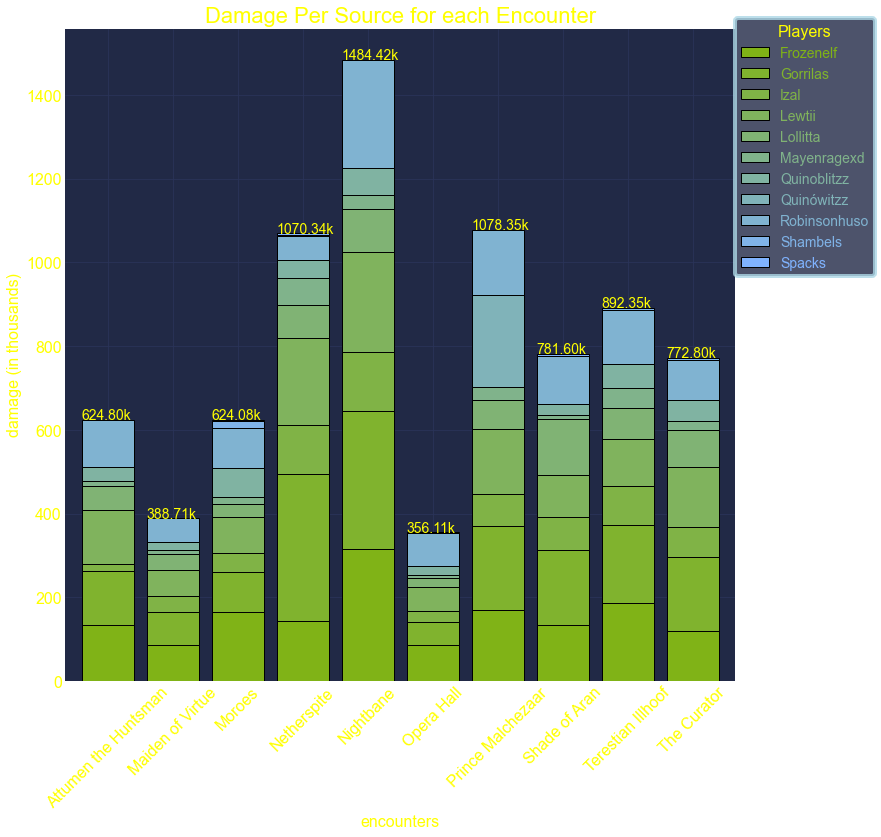

In [489]:
dmg = data["sum"]/1e3

def color_gen(size):
    step = 1/float(size)
    return [(0.5,0.7,step*i) for i in range(1,1+size,1)]
    
colors = color_gen(len(dmg.columns))

ax = dmg.plot.bar(
                  figsize=(12,12),
                  stacked=True,
                  edgecolor = 'black',
                  width = 0.8,
                 color = colors)
ax.set_title("Damage Per Source for each Encounter")
ax.set_xlabel("encounters")
ax.set_ylabel("damage (in thousands)")

ax.title.set_size('22')
ax.xaxis.label.set_size('16')
ax.yaxis.label.set_size('16')

ax.title.set_color('yellow')
ax.xaxis.label.set_color('yellow')
ax.yaxis.label.set_color('yellow')


for i , patch in enumerate(ax.patches):
    ax.text(
        patch.get_x(),
        data["total"][i]/1e3,
        '{:1.2f}k'.format(data["total"][i]/1e3),
        size = 14,
        color='yellow')
    if i> len(dmg.index)-2: break

####CUSTOM LEGENDS
all_mpatches = []
f = lambda x:1
cnt = 0
for column in dmg.columns:
    all_mpatches.append(mpatches.Patch(label = column[-1]))
    cnt += 1
    
leg = ax.legend(prop = {'size':14},
                loc = 0,
                fancybox=True,
                frameon = True,
                title = 'Players',
                bbox_to_anchor = (1.07,0.9),
               labelcolor = 'linecolor',
               bbox_transform = plt.gcf().transFigure
               )
plt.setp(leg.get_title(),color='yellow',size=16)
leg.get_frame().set_edgecolor('lightblue')
leg.get_frame().set_linewidth(4)

#####SETTING TICKS
ax.tick_params(axis='x',labelcolor='yellow',labelsize=16,rotation=45)
ax.tick_params(axis='y',labelcolor='yellow',labelsize=16)

<center>
<span style="color:MediumSeaGreen;">
<span style="font-family:Brush Script MT;">
<font size="8"> Damage Per Second (Source)
</font>
</span>
</span>
</center>

In [490]:
import datetime

def transform_time(x) -> float:
    x = str(x)
    if '.' not in x: x += '.0'
    return datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f').timestamp()*1000

def time_in_combat(starts:str,y:str):
    return transform_time(y) - transform_time(starts)

@set_clock
def damage_dealt_table(encounter_name:str,source_name:str,df:pd.DataFrame):
    data = df.loc[(df.encounter == f'{encounter_name}') & (df.source == f'{source_name}')]
    starts = data["combat_time"].iloc[0]
    data["combat_time"] = data["combat_time"].apply(lambda x:time_in_combat(starts,x))/1e3
    bins = np.arange(0,round(data["combat_time"].iloc[-1]),1)
    data["time_interval"] = pd.cut(data["combat_time"],bins=bins,include_lowest=True)
    data = data[["mitigated_damage","time_interval"]].groupby("time_interval").sum()
    return data

dmg = damage_dealt_table("Nightbane","Lollitta",df)
dmg["time"] = np.arange(0,len(dmg),1)
fig = px.line(dmg, x = "time" , y = "mitigated_damage",title="Encounter Nightbane")
fig.update_layout(
    plot_bgcolor="white"
)
fig.show()

Process completed in 0.04 second(s).

C:\Users\30697\AppData\Local\Temp/ipykernel_33804/3725697.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\30697\AppData\Local\Temp/ipykernel_33804/3725697.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [491]:
with SQL("wowlogsdb") as conn:
    cursor = conn.cursor()
    cursor.execute("SHOW TABLES;")
    result = cursor.fetchall()
    for r in result: print(r)

('bosses',)
('buff',)
('clog',)
('damage',)
('encounter',)
('encounters',)
('heal',)
('log1',)
('log2',)
('log3',)
('spells',)
('wow_combat_log_1',)


In [449]:
with SQL("wowlogsdb") as conn:
    cursor = conn.cursor()
    cursor.execute("DESCRIBE spells;")
    result = cursor.fetchall()
    for r in result: print(r)

('rowid', b'int unsigned', 'NO', 'PRI', None, 'auto_increment')
('spell_name', b'varchar(50)', 'NO', '', None, '')
('class', b'varchar(50)', 'NO', '', None, '')
('school', b'varchar(50)', 'NO', '', None, '')
('type', b'varchar(50)', 'YES', '', None, '')
('spec', b'varchar(50)', 'YES', '', None, '')
('rank', b'int', 'YES', '', None, '')
('cooldown', b'decimal(10,0)', 'NO', '', None, '')
('casting time', b'decimal(10,0)', 'YES', '', None, '')
('cost', b'int', 'YES', '', None, '')


In [614]:
with SQL("wowlogsdb") as conn:
    cursor = conn.cursor()
    cursor.execute("SELECT spell_name , class , cost FROM spells;")
    result = cursor.fetchall()
    print('spell_name','class','cost')
    for r in result: print(r)

spell_name class cost
('Berserker Stance', 'Warrior', 0)
('Defensive Stance', 'Warrior', 0)
('Battle Stance', 'Warrior', 0)
('Sunder Armor', 'Warrior', 15)
('Retaliation', 'Warrior', 0)
('Cleave', 'Warrior', 20)
('Whirlwind', 'Warrior', 25)
('Pummel', 'Warrior', 10)
('Recklessness', 'Warrior', 0)
('Intercept', 'Warrior', 10)
('Deep Wound', 'Warrior', 0)
('Heroic Strike', 'Warrior', 15)
('Execute', 'Warrior', 15)
('Rend', 'Warrior', 10)
('Slam', 'Warrior', 15)
('Revenge', 'Warrior', 5)
('Shield Bash', 'Warrior', 10)
('Shield Slam', 'Warrior', 20)
('Bloodthirst', 'Warrior', 30)
('Mortal Strike', 'Warrior', 30)
('Hamstring', 'Warrior', 10)
('Demoralizing Shout', 'Warrior', 10)
('Shield Wall', 'Warrior', 0)
('Charge', 'Warrior', 0)
('Shield Block', 'Warrior', 10)
('Battle Shout', 'Warrior', 10)
('Spell Reflection', 'Warrior', 25)
('Intervene', 'Warrior', 10)
('Bloodrage', 'Warrior', 0)
('Disarm', 'Warrior', 20)
('Mocking Blow', 'Warrior', 10)
('Thunder Clap', 'Warrior', 20)
('Overpower', '

In [615]:
df.head(3).style.background_gradient(cmap='summer')

,combat_time,log_event,encounter,spell_name,source,source_is_human,dest,dest_is_human,school,mitigated_damage,raw_damage,combat_event,blocked,resisted,absorbed,mitigated_norm
0,2021-12-12 02:52:31.528000,SWING_DAMAGE,Attumen the Huntsman,Auto Attack,Midnight,0,Lollitta,1,Physical,2020,5984,normal,344,0,0,-11984.763840
1,2021-12-12 02:52:31.528000,SPELL_DAMAGE,Attumen the Huntsman,Devastate,Lollitta,1,Midnight,0,Physical,94,156,normal,0,0,0,-11986.804801
2,2021-12-12 02:52:31.732000,SWING_DAMAGE,Attumen the Huntsman,Auto Attack,Lollitta,1,Midnight,0,Physical,188,304,normal,0,0,0,-11986.705190


In [455]:
with SQL("wowlogsdb") as conn:
    rage_costs = pd.read_sql("SELECT spell_name, class , cost FROM spells",con=conn)
rage_costs.style.background_gradient(cmap='summer')

,spell_name,class,cost
0,Berserker Stance,Warrior,0
1,Defensive Stance,Warrior,0
2,Battle Stance,Warrior,0
3,Sunder Armor,Warrior,15
4,Retaliation,Warrior,0
5,Cleave,Warrior,20
6,Whirlwind,Warrior,25
7,Pummel,Warrior,10
8,Recklessness,Warrior,0
9,Intercept,Warrior,10


In [635]:
@set_clock
def fetch_table(encounter_name:str,source_name:str,cost_table:pd.DataFrame,damage_table:pd.DataFrame):
    damage_table = damage_table.loc[(damage_table["encounter"] == encounter_name.strip())
                                   & (damage_table["source"] == source_name.strip())]
    return pd.merge(damage_table,cost_table,how='left')

cost = fetch_table("Attumen the Huntsman","Lollitta",rage_costs,df)
cost[["spell_name","mitigated_damage","raw_damage","cost"]].style.background_gradient(cmap='summer')

Process completed in 0.01 second(s).

,spell_name,mitigated_damage,raw_damage,cost
0,Devastate,94,156,15.000000
1,Auto Attack,188,304,0.000000
2,Revenge,268,434,5.000000
3,Auto Attack,0,0,0.000000
4,Auto Attack,130,318,0.000000
5,Devastate,160,259,15.000000
6,Auto Attack,164,314,0.000000
7,Shield Slam,491,772,20.000000
8,Heroic Strike,244,452,15.000000
9,Devastate,208,316,15.000000


In [636]:
starts = cost["combat_time"].iloc[0]
cost["combat_time"] = cost["combat_time"].apply(lambda x:time_in_combat(starts,x)/1e3)

In [637]:
cost.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 0 to 220
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   combat_time       221 non-null    float64
 1   log_event         221 non-null    object 
 2   encounter         221 non-null    object 
 3   spell_name        221 non-null    object 
 4   source            221 non-null    object 
 5   source_is_human   221 non-null    int64  
 6   dest              221 non-null    object 
 7   dest_is_human     221 non-null    int64  
 8   school            221 non-null    object 
 9   mitigated_damage  221 non-null    int64  
 10  raw_damage        221 non-null    int64  
 11  combat_event      221 non-null    object 
 12  blocked           221 non-null    int64  
 13  resisted          221 non-null    int64  
 14  absorbed          221 non-null    int64  
 15  mitigated_norm    221 non-null    float64
 16  class             218 non-null    object 
 1

<AxesSubplot:>

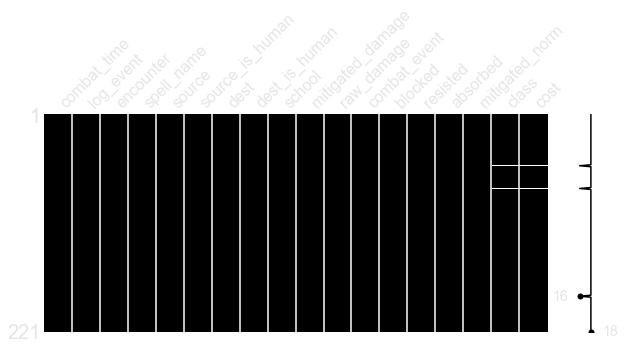

In [638]:
mn.matrix(cost,color=(0,0,0),figsize=(10,4))

In [639]:
cost.isna().values.sum(axis=0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3])

In [640]:
def nan_matrix(df:pd.DataFrame) -> pd.DataFrame:
    missing = df.isnull().values.sum(axis=0)
    total = len(df)
    missing = pd.DataFrame({col:[missing[i],total-missing[i]] for i , col in enumerate(df.columns)}).T
    missing.columns = ["Not Missing","Missing"]
    missing['perc'] = missing.apply(lambda x:'{:1.2f}%'.format(x[0]*100/(x[0]+x[1])),axis=1)
    return missing[missing["Not Missing"]>0]

nan = nan_matrix(cost)
nan.style.background_gradient(cmap='summer')

,Not Missing,Missing,perc
class,3,218,1.36%
cost,3,218,1.36%


In [641]:
cost[cost.isna().values.any(axis=1)].loc[:,"spell_name":]

,spell_name,source,source_is_human,dest,dest_is_human,school,mitigated_damage,raw_damage,combat_event,blocked,resisted,absorbed,mitigated_norm,class,cost
52,Romulo's Poison,Lollitta,1,Midnight,0,Nature,301,301,normal,0,0,0,-11986.585445,NaN,NaN
75,Romulo's Poison,Lollitta,1,Midnight,0,Nature,303,303,normal,0,0,0,-11986.583326,NaN,NaN
184,Romulo's Poison,Lollitta,1,Attumen the Huntsman,0,Nature,230,229,normal,0,0,0,-11986.660683,NaN,NaN


<span style="color:yellow;">
<span style="font-family:Comic Sans MS;">
<font size="4"> We notice that the damage PROC event from Romulo's Poison trinket has NaN value in the cost column. This is probably due to the fact that in general PROCs & various trigger events consist free meals in damage distribution. Hence, those NaN values should not be dropped but instead be replaced by 0. Moreover, the class column is NaN due to those being generic and not class specific abilities.
    </font>
    </span>
    </span>

In [642]:
cost["cost"] = cost["cost"].fillna(0)
cost["class"] = cost["class"].fillna("Generic")

In [643]:
nan_matrix(cost)

,Not Missing,Missing,perc


In [644]:
#Hence NaN are eliminated.

In [650]:
@set_clock
def fetch_cost_table(encounter_name:str,cost:pd.DataFrame) -> pd.DataFrame:
    grped = (cost[["encounter","source","spell_name","mitigated_damage","cost"]]
           .loc[(df["encounter"] == encounter_name.strip()) & (df["source"] == 'Lollitta')]
           .groupby("spell_name")
           .sum()
           .sort_values("mitigated_damage",ascending=False)
        )
    total_cost = float(grped["cost"].sum())
    total_damage = float(grped["mitigated_damage"].sum())
    grped["perc_dmg"] = grped["mitigated_damage"].apply(lambda x:x*100/total_damage)
    grped["perc_cost"] = grped["cost"].apply(lambda x:x*100/total_cost)
    grped["cost"] = grped["cost"].astype(int)
    return grped

f = {"perc_dmg":'{:.2f}',"perc_cost":'{:.2f}'}
cost_dmg_table = fetch_cost_table("Attumen the Huntsman",cost)
cost_dmg_table.style.format(f).background_gradient(cmap='spring')

Process completed in 0.01 second(s).

,mitigated_damage,cost,perc_dmg,perc_cost
spell_name,,,,
Execute,3101,30,32.01,13.04
Cleave,1476,100,15.24,43.48
Revenge,1321,15,13.64,6.52
Auto Attack,1289,0,13.31,0.00
Heroic Strike,1262,45,13.03,19.57
Shield Slam,1089,40,11.24,17.39
Deep Wound,149,0,1.54,0.00


<AxesSubplot:xlabel='spell_name'>

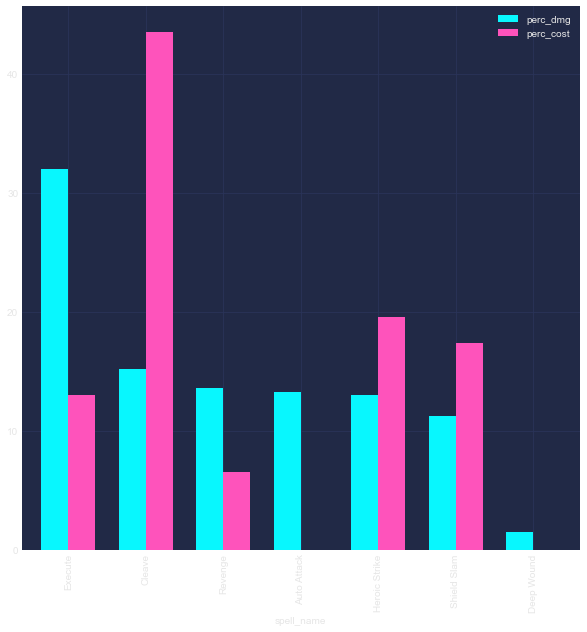

In [651]:
cost_dmg_table[["perc_dmg","perc_cost"]].plot(
                                        figsize=(10,10),
                                        kind='bar',
                                        width=0.7)

In [657]:
cost["mitigated_norm"] = (cost["mitigated_damage"] - cost["mitigated_damage"].mean())/cost["mitigated_damage"].std()
cost["cost_norm"] = (cost["cost"] - cost["cost"].mean())/cost["cost"].std()
cost["cum_dmg"] = cost["mitigated_norm"].cumsum()
cost["cum_cost"] = cost["cost_norm"].cumsum()
cost.head(3)

,combat_time,log_event,encounter,spell_name,source,source_is_human,dest,dest_is_human,school,mitigated_damage,...,combat_event,blocked,resisted,absorbed,mitigated_norm,class,cost,cost_norm,cum_dmg,cum_cost
0,0.000,SPELL_DAMAGE,Attumen the Huntsman,Devastate,Lollitta,1,Midnight,0,Physical,94,...,normal,0,0,0,-0.562062,Warrior,15.0,0.785618,-0.562062,0.785618
1,0.204,SWING_DAMAGE,Attumen the Huntsman,Auto Attack,Lollitta,1,Midnight,0,Physical,188,...,normal,0,0,0,-0.252289,Generic,0.0,-0.992077,-0.814350,-0.206459
2,1.509,SPELL_DAMAGE,Attumen the Huntsman,Revenge,Lollitta,1,Midnight,0,Physical,268,...,normal,0,0,0,0.011348,Warrior,5.0,-0.399512,-0.803003,-0.605971


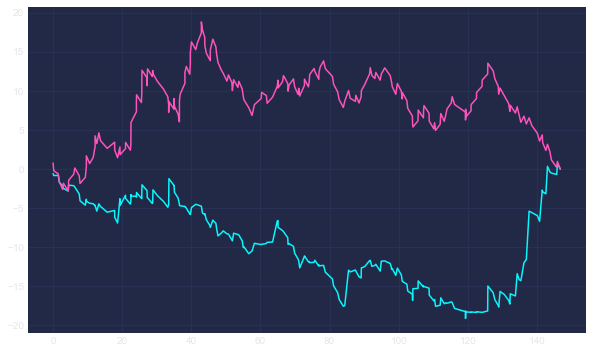

In [659]:
fig , ax = plt.subplots(ncols=1,nrows=1,figsize=(10,6))
ax.plot(cost["combat_time"],cost["cum_dmg"])
ax.plot(cost["combat_time"],cost["cum_cost"])

<center>
<span style="color:MediumSeaGreen;">
<span style="font-family:Brush Script MT;">
<font size="8"> Cumulative Damage
</font>
</span>
</span>
</center>

Process completed in 0.09 second(s).

C:\Users\30697\AppData\Local\Temp/ipykernel_33804/2709679528.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\30697\AppData\Local\Temp/ipykernel_33804/2709679528.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



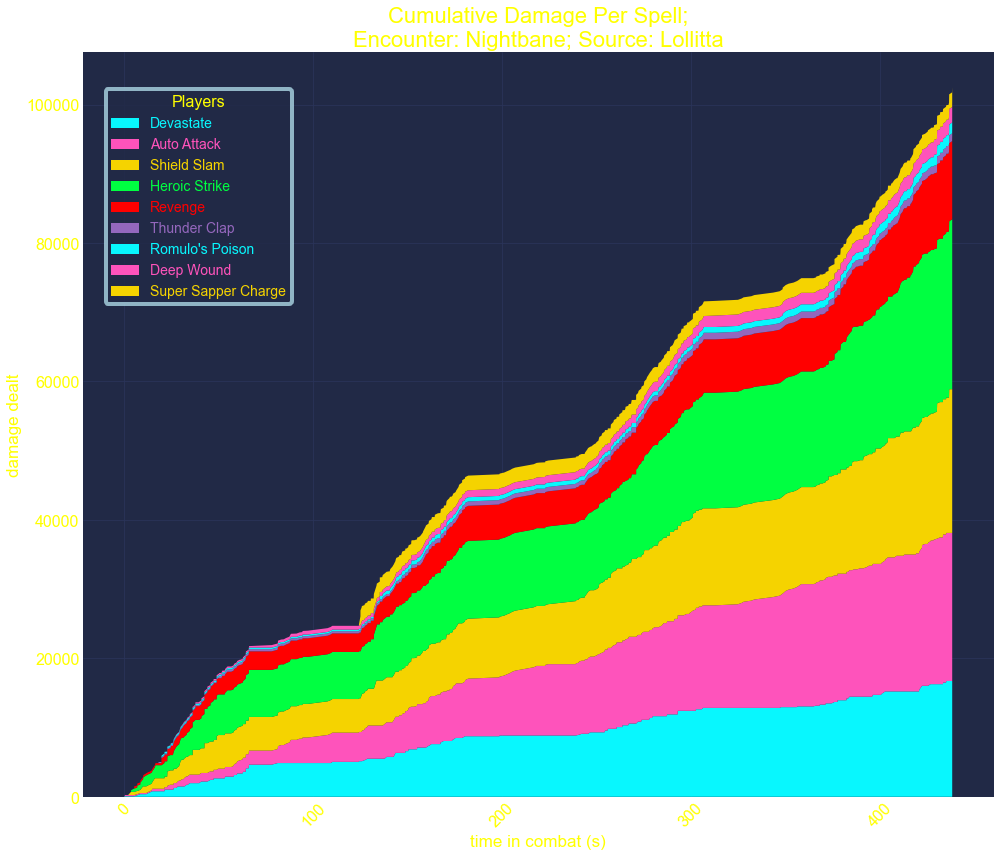

In [445]:
colors = {"Shield Slam":"purple",
          "Auto Attack":"white",
         "Devastate":"blue",
         "Heroic Strike":"yellow",
         "Deep Wound":"orange",
         "Revenge":"grey",
         "Romulo\'s Poison":"pink",
         "Execute":"red",
         "Thunder Clap":"pink",
         "Super Sapper Charge":"blue"}

def transform_damage(x,spell_name:str):
    """Returns the damage dealt if the spell argument matches with the spell name in the 
       row which we apply the transformation."""
    return x[0] if spell_name.strip() == x[1] else 0

@set_clock
def cumsum_spells(encounter_name:str,source_name:str,df:pd.DataFrame) -> pd.DataFrame:
    df = df.loc[(df.encounter == f'{encounter_name}') & (df.source == f'{source_name}')]
    starts = df["combat_time"].iloc[0]
    df["combat_time"] = df["combat_time"].apply(lambda x:time_in_combat(starts,x))/1e3
    spells = df['spell_name'].unique()
    for spell in spells:
        df[spell] = (df[['mitigated_damage','spell_name']]
                          .apply(lambda x:transform_damage(x,spell),axis=1)
                          .cumsum())
        #if df[spell].loc[-1] == 0: df.drop(columns=[spell],inplace=True)
    return df

source = "Lollitta"
encounter = "Nightbane"
df2 = cumsum_spells("Nightbane","Lollitta",df)
fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(111)
ax.stackplot(
              df2["combat_time"],
              df2[df2.columns[len(df2.columns)-len(df2["spell_name"].unique()):]].T,
              labels = df2["spell_name"].unique()
            )
ax.legend(loc=0)
ax.set_title(f"Cumulative Damage Per Spell;\nEncounter: {encounter}; Source: {source}")
ax.set_xlabel("time in combat (s)")
ax.set_ylabel("damage dealt")

ax.title.set_size('22')
ax.xaxis.label.set_size('17')
ax.yaxis.label.set_size('17')

ax.title.set_color('yellow')
ax.xaxis.label.set_color('yellow')
ax.yaxis.label.set_color('yellow')

all_mpatches = []
f = lambda x:1
cnt = 0
for column in df2.columns:
    all_mpatches.append(mpatches.Patch(label = column[-1]))
    cnt += 1
    
leg = ax.legend(prop = {'size':14},
                loc = 0,
                fancybox=True,
                frameon = True,
                title = 'Players',
                bbox_to_anchor = (0.3,0.9),
               labelcolor = 'linecolor',
               bbox_transform = plt.gcf().transFigure
               )
plt.setp(leg.get_title(),color='yellow',size=16)
leg.get_frame().set_edgecolor('lightblue')
leg.get_frame().set_linewidth(4)
#####SETTING TICKS
ax.tick_params(axis='x',labelcolor='yellow',labelsize=16,rotation=45)
ax.tick_params(axis='y',labelcolor='yellow',labelsize=16)

plt.tight_layout()

<center>
<span style="color:MediumSeaGreen;">
<span style="font-family:Brush Script MT;">
<font size="8"> Action Swing Timer
</font>
</span>
</span>
</center>

C:\Users\30697\AppData\Local\Temp/ipykernel_33804/2543526806.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\30697\AppData\Local\Temp/ipykernel_33804/2543526806.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\30697\AppData\Local\Temp/ipykernel_33804/2543526806.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

(array([ 7.,  6.,  9., 13.,  8.,  2.,  2.,  2.,  4.,  3.,  7.,  4.,  1.,
         5.,  6.,  8.,  6.,  4.,  4.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  2.,  1.]),
 array([0.        , 0.08483333, 0.16966667, 0.2545    , 0.33933333,
        0.42416667, 0.509     , 0.59383333, 0.67866667, 0.7635    ,
        0.84833333, 0.93316667, 1.018     , 1.10283333, 1.18766667,
        1.2725    , 1.35733333, 1.44216667, 1.527     , 1.61183333,
        1.69666667, 1.7815    , 1.86633333, 1.95116667, 2.036     ,
        2.12083333, 2.20566667, 2.2905    , 2.37533333, 2.46016667,
        2.545     ]),
 <BarContainer object of 30 artists>)

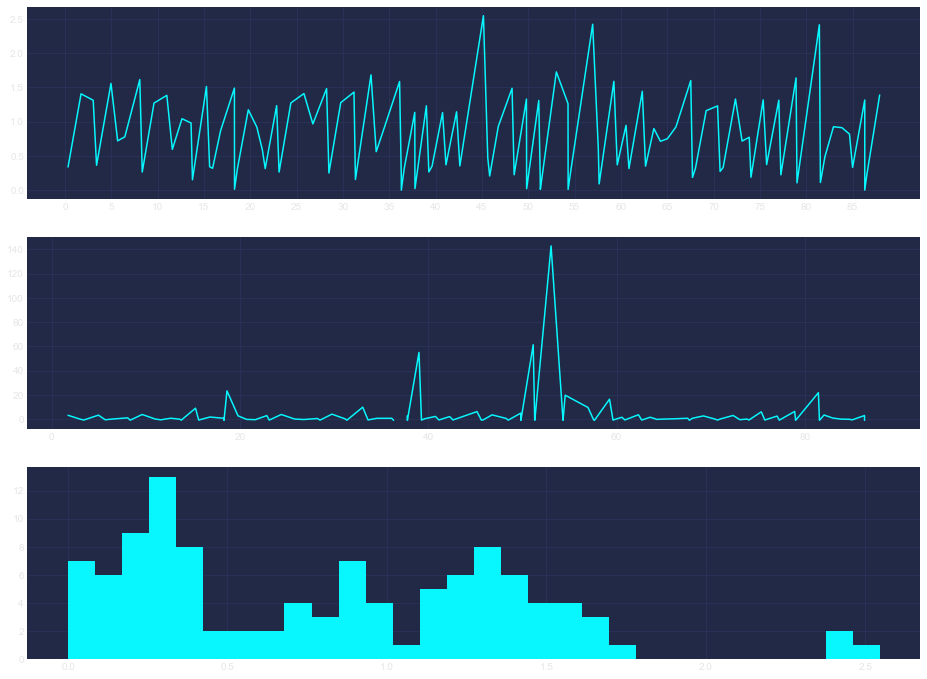

In [230]:
def swing_timer(encounter_name:str,source_name:str,df:pd.DataFrame) -> pd.DataFrame:
    df2 = df.loc[(df.encounter == f'{encounter_name}') & (df.source == f'{source_name}')]
    starts = df2["combat_time"].iloc[0]
    df2["combat_time"] = df2["combat_time"].apply(lambda x:time_in_combat(starts,x))/1e3
    df2['swing_timer'] = (df2["combat_time"].rolling(2)
                                            .apply(lambda x:x.iloc[1] - x.iloc[0])
                      )
    df2["prc_change"] = df2["swing_timer"].pct_change()
    return df2

df2 = swing_timer("Maiden of Virtue","Lollitta",df)
fig , (ax1,ax2,ax3) = plt.subplots(nrows=3,ncols=1,figsize=(16,12))
ax1.plot(df2["combat_time"],df2["swing_timer"])
ax1.set_xticks(np.arange(0,df2["combat_time"].iloc[-1],5))
ax2.plot(df2["combat_time"],df2["prc_change"])
ax3.hist(df2["swing_timer"],bins=30)

(array([ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  1.,  0.,  1.,  4.,  0., 13.,  8.,  0.,  0.,  0.,
         2.,  0.,  0.,  1.]),
 array([0.25      , 0.36076667, 0.47153333, 0.5823    , 0.69306667,
        0.80383333, 0.9146    , 1.02536667, 1.13613333, 1.2469    ,
        1.35766667, 1.46843333, 1.5792    , 1.68996667, 1.80073333,
        1.9115    , 2.02226667, 2.13303333, 2.2438    , 2.35456667,
        2.46533333, 2.5761    , 2.68686667, 2.79763333, 2.9084    ,
        3.01916667, 3.12993333, 3.2407    , 3.35146667, 3.46223333,
        3.573     ]),
 <BarContainer object of 30 artists>)

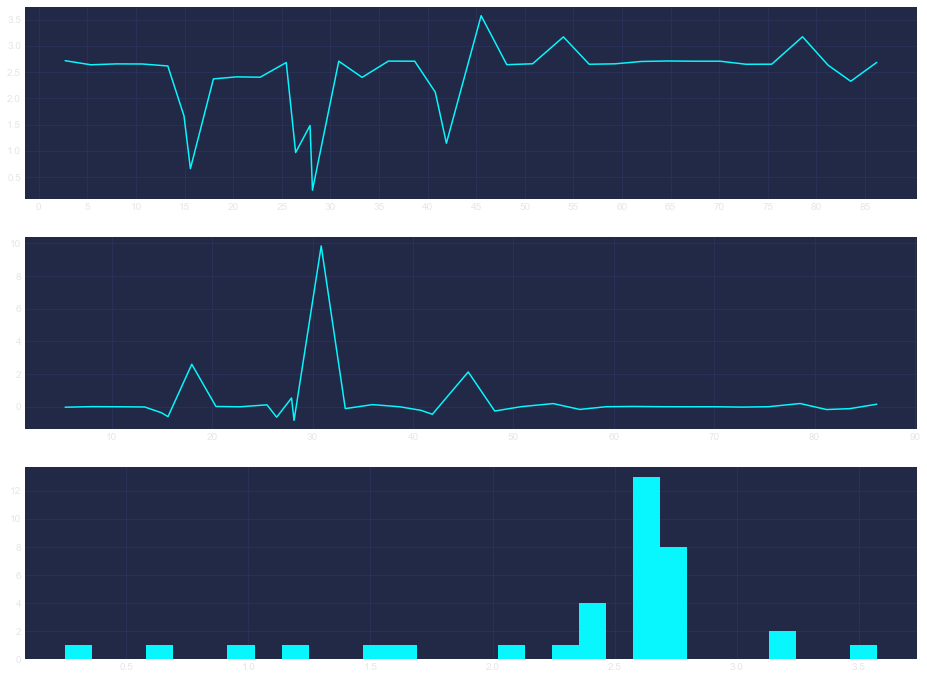

In [234]:
def swing_timer(encounter_name:str,source_name:str,df:pd.DataFrame) -> pd.DataFrame:
    df2 = df.loc[(df.encounter == f'{encounter_name}') & 
                 (df.source == f'{source_name}')]
    df2 = df2.loc[(df.spell_name == "Auto Attack") | (df.spell_name == "Heroic Strike")
                  | (df.spell_name == "Cleave") ]
    starts = df2["combat_time"].iloc[0]
    df2["combat_time"] = df2["combat_time"].apply(lambda x:time_in_combat(starts,x))/1e3
    df2['swing_timer'] = (df2["combat_time"].rolling(2)
                                            .apply(lambda x:x.iloc[1] - x.iloc[0])
                      )
    df2["prc_change"] = df2["swing_timer"].pct_change()
    return df2

df2 = swing_timer("Maiden of Virtue","Lollitta",df)
fig , (ax1,ax2,ax3) = plt.subplots(nrows=3,ncols=1,figsize=(16,12))
ax1.plot(df2["combat_time"],df2["swing_timer"])
ax1.set_xticks(np.arange(0,df2["combat_time"].iloc[-1],5))
ax2.plot(df2["combat_time"],df2["prc_change"])
ax3.hist(df2["swing_timer"],bins=30)

<center>
<span style="color:MediumSeaGreen;">
<span style="font-family:Brush Script MT;">
<font size="8"> Spell Damage
</font>
</span>
</span>
</center>

{'bodies': [<matplotlib.collections.PolyCollection at 0x154286c0130>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x154286a6fa0>,
 'cmins': <matplotlib.collections.LineCollection at 0x154286c06a0>,
 'cbars': <matplotlib.collections.LineCollection at 0x154286c09d0>}

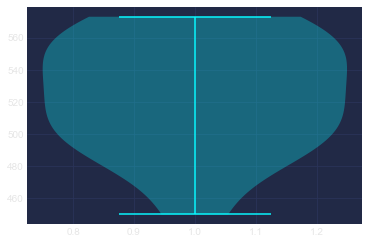

In [419]:
df2 = df.loc[(df.source == 'Lollitta') & (df.encounter == 'Maiden of Virtue')]
plt.violinplot(df2[(df2['spell_name'] == 'Heroic Strike')
                   & (df2["combat_event"] == "normal")]["mitigated_damage"])

In [420]:
df2["spell_name"].unique()

array(['Shield Slam', 'Auto Attack', 'Devastate', 'Heroic Strike',
       'Deep Wound', 'Revenge', "Romulo's Poison", 'Execute'],
      dtype=object)

In [421]:
colors = {"Shield Slam":"purple",
          "Auto Attack":"white",
         "Devastate":"blue",
         "Heroic Strike":"yellow",
         "Deep Wound":"orange",
         "Revenge":"grey",
         "Romulo\'s Poison":"pink",
         "Execute":"red"}

C:\Users\30697\AppData\Local\Temp/ipykernel_33804/1054635529.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



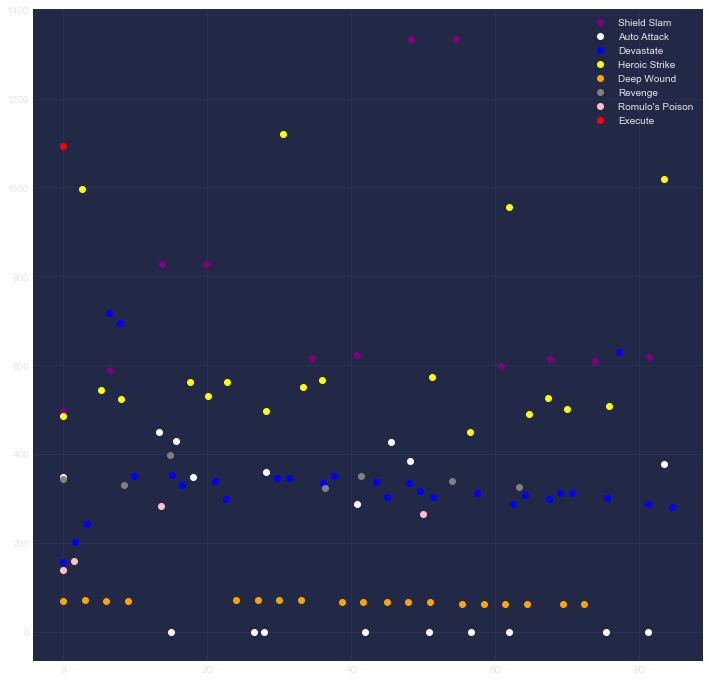

In [422]:
plt.figure(figsize=(12,12))
for spell in df2["spell_name"].unique():
    df3 = df2.loc[df2.spell_name == spell]
    starts = df3["combat_time"].iloc[0]
    df3["combat_time"] = df3["combat_time"].apply(lambda x:time_in_combat(starts,x))/1e3
    plt.scatter(df3["combat_time"],df3["mitigated_damage"],
                color=colors[spell],
               label = spell)
plt.legend(loc=0)

<center>
<span style="color:MediumSeaGreen;">
<span style="font-family:Brush Script MT;">
<font size="8"> Uncrushability
</font>
</span>

In [608]:
with SQL("wowlogsdb") as conn:
    curs = conn.cursor()
    curs.execute("SHOW TABLES;")
    for r in curs.fetchall(): print(r)

('bosses',)
('buff',)
('clog',)
('damage',)
('encounter',)
('encounters',)
('heal',)
('log1',)
('log2',)
('log3',)
('spells',)
('wow_combat_log_1',)


In [610]:
with SQL("wowlogsdb") as conn:
    aura_data = pd.read_sql("SELECT * FROM buff;",con=conn)
aura_data.head().style.background_gradient(cmap='spring')

,rowid,combat_time,log_event,encounter,spell_name,source,source_is_human,dest,dest_is_human,applied,type
0,1,2021-12-12 02:52:30.195000,SPELL_AURA_REMOVED,Attumen the Huntsman,Battle Stance,Lollitta,1,Lollitta,1,0,BUFF
1,2,2021-12-12 02:52:30.195000,SPELL_AURA_APPLIED,Attumen the Huntsman,Defensive Stance,Lollitta,1,Lollitta,1,1,BUFF
2,3,2021-12-12 02:52:31.343000,SPELL_AURA_APPLIED,Attumen the Huntsman,Faerie Fire,Lewtii,1,Midnight,0,1,DEBUFF
3,4,2021-12-12 02:52:31.528000,SPELL_AURA_APPLIED,Attumen the Huntsman,Sunder Armor,Lollitta,1,Midnight,0,1,DEBUFF
4,5,2021-12-12 02:52:31.547000,SPELL_AURA_REMOVED,Attumen the Huntsman,Prayer of Mending,Spacks,1,Lollitta,1,0,BUFF


<!DOCTYPE html>
<html>
<center>
<style>
body {
  font-size: 15px;
}
</style>
<body>
    <center>
    <span style="color:MediumSeaGreen;">
<span style="font-family:Brush Script MT;">
<font size="14"> To Be Continued ... 
</font>
</span>
        <br>
            <p>
    <span style='font-size:100px;'>&#9935;</span>
        </p>
        </body>
    </center>
</html>